In [ ]:
%load_ext Cython
import torch
import torch.nn as nn
import torch.nn.functional as F
import tensorflow as tf
# from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim
import pandas as pd
import numpy as np
import os
import time
from sklearn.metrics import cohen_kappa_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
os.chdir("/Users/damansharma/Desktop/data/petfinder-adoption-prediction")

In [ ]:
petidcsv = pd.read_csv("/content/drive/My Drive/3rd Year/APS360 Project/Final CSV Files/finalTest.csv")
petidcsv = petidcsv[["PetID"]]
petidcsv

,PetID
0,e2dfc2935
1,f153b465f
2,3c90f3f54
3,e02abc8a3
4,09f0df7d1
...,...
3967,ae57f8d52
3968,83432904d
3969,399013029
3970,fd80b8c80


In [ ]:
os.getcwd()

'/Users/damansharma/Desktop/data/petfinder-adoption-prediction'

In [ ]:
os.listdir("..")

['.DS_Store', 'petfinder-adoption-prediction']

In [ ]:
# Load image adoption speed
trainAdoptionSpeed = pd.read_csv('/content/drive/My Drive/3rd Year/APS360 Project/trainWithImageData1.csv', index_col=False)
testAdoptionSpeed = pd.read_csv('/content/drive/My Drive/3rd Year/APS360 Project/csvWithImageData/testWithImageData.csv', index_col=False)

In [ ]:
def splitDataAndBalance(dataTable):
    trainingIndex = round(len(dataTable)*0.7)

    tDataset = dataTable[:trainingIndex]
    vDataset = dataTable[trainingIndex:]

    adoptionSpeedCounts = tDataset['AdoptionSpeed'].value_counts()
    
    maxIndex = adoptionSpeedCounts.idxmax()
    print(adoptionSpeedCounts)
    
    for index, count in adoptionSpeedCounts.iteritems():
        if index == maxIndex:
            continue;
        adoptionSpeedRows = tDataset[tDataset['AdoptionSpeed'] == index]
        adoptionSpeedDuplicateRows = adoptionSpeedRows.sample(adoptionSpeedCounts[maxIndex]-count, replace=True)
        tDataset = pd.concat([tDataset, adoptionSpeedDuplicateRows], axis=0)
    adoptionSpeedCounts = tDataset['AdoptionSpeed'].value_counts()
    print(adoptionSpeedCounts)

    tDataset = tDataset.values.astype(np.float32)
    vDataset = vDataset.values.astype(np.float32)
    
    return tDataset, vDataset    

In [ ]:
delete_features = ["Name", "RescuerID", "VideoAmt", "Description", "PhotoAmt"]
pandaCSV = pd.read_csv("/content/drive/My Drive/APS360 Project/Final CSV Files/finalTrain.csv", index_col=False)
originalTable = pandaCSV.drop(delete_features, axis=1)

#originalTable['ImageAdoptionSpeed'] = trainAdoptionSpeed['Pred (0.5 Default Value)']
# originalTable = originalTable[['Type','Age','Breed1','Breed2','Gender','Color1','Color2','Color3','MaturitySize',
#                               'FurLength','Vaccinated','Dewormed','Sterilized','Health','Quantity','Fee','State',
#                               'SentimentScore','ImageAdoptionSpeed','PetID','AdoptionSpeed']]
originalTable = originalTable[['Type','Age','Breed1','Breed2','Gender','Color1','Color2','Color3','MaturitySize',
                               'FurLength','Vaccinated','Dewormed','Sterilized','Health','Quantity','Fee','State',
                               'SentimentScore', 'BreedRating', 'Emotion', 'Age_binary', 'PetID','AdoptionSpeed']]
originalTable

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,SentimentScore,BreedRating,Emotion,Age_binary,PetID,AdoptionSpeed
0,2,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,0.3,0,0.100000,0,86e1089a3,2
1,2,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,-0.2,0,0.120000,0,6296e909a,0
2,1,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,0.2,0,0.144444,0,3422e4906,3
3,1,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,0.9,0,0.120000,0,5842f1ff5,2
4,1,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,0.6,0,0.100000,0,850a43f90,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14988,2,2,266,0,3,1,0,0,2,2,2,2,2,1,4,0,41326,0.4,0,0.120000,0,dc0935a84,2
14989,2,60,265,264,3,1,4,7,2,2,1,1,1,1,2,0,41326,0.0,0,0.140000,1,a01ab5b30,4
14990,2,2,265,266,3,5,6,7,3,2,2,1,3,1,5,30,41326,0.8,0,0.125000,0,d981b6395,3
14991,2,9,266,0,2,4,7,0,1,1,1,1,1,1,1,0,41336,0.9,0,0.125000,0,e4da1c9e4,4


In [ ]:
# originalTable['MaturitySize'] = originalTable['MaturitySize'].replace(0, np.nan)
# originalTable['FurLength'] = originalTable['FurLength'].replace(0, np.nan)
#originalTable['Vaccinated'] = originalTable['Vaccinated'].replace(3, 0)
#originalTable['Dewormed'] = originalTable['Dewormed'].replace(3, 0)
#originalTable['Sterilized'] = originalTable['Sterilized'].replace(3, 0)
# originalTable['Health'] = originalTable['Health'].replace(0, np.nan)

originalTable.loc[originalTable.index, 'PetID'] = originalTable.index

# Normalize Table Values (Between 0 and 1)
minColumns = np.amin(originalTable, axis = 0)
maxColumns = np.amax(originalTable, axis = 0)

i = 0
for col in originalTable.columns: 
    if "AdoptionSpeed" in col or "PetID" in col or "SentimentScore" in col or "Emotion" in col or "BreedRating" in col:
        continue
    #originalTable[col] = np.where(originalTable[col] != np.nan, (originalTable[col] - minColumns[i])/(maxColumns[i] - minColumns[i]), np.nan)
#     originalTable.loc[originalTable.col != np.nan, col] = (originalTable.col - minColumns[i])/(maxColumns[i] - minColumns[i])
    originalTable[col] = (originalTable[col] - minColumns[i])/(maxColumns[i] - minColumns[i])
#     print(col)
    i += 1

print(originalTable.isnull().sum(axis = 0))

# ANN No. 1 (Adoption Speeds should be 0 or 1)
ANNOneTable = originalTable.copy()

# # TEMP
kaggle_submission_table = originalTable[['PetID','AdoptionSpeed']].copy()
kaggle_submission_table.loc[:, 'AdoptionSpeed'] = None  

ANNOneTable['AdoptionSpeed'] = np.where(ANNOneTable['AdoptionSpeed'] < 3, 0, 1)

train_ANNOne_dataset, valid_ANNOne_dataset = splitDataAndBalance(ANNOneTable)

Type              0
Age               0
Breed1            0
Breed2            0
Gender            0
Color1            0
Color2            0
Color3            0
MaturitySize      0
FurLength         0
Vaccinated        0
Dewormed          0
Sterilized        0
Health            0
Quantity          0
Fee               0
State             0
SentimentScore    0
BreedRating       0
Emotion           0
Age_binary        0
PetID             0
AdoptionSpeed     0
dtype: int64
1    5267
0    5228
Name: AdoptionSpeed, dtype: int64
1    5267
0    5267
Name: AdoptionSpeed, dtype: int64


In [ ]:
ANNOneTable

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,SentimentScore,BreedRating,Emotion,Age_binary,PetID,AdoptionSpeed
0,1.0,0.011765,0.973941,0.000000,0.0,0.000000,1.000000,0.0,0.000000,0.0,0.5,0.5,0.5,0.0,0.000000,0.033333,0.021978,0.3,0,0.100000,0.500000,0,0
1,1.0,0.003922,0.863192,0.000000,0.0,0.000000,0.285714,0.0,0.333333,0.5,1.0,1.0,1.0,0.0,0.000000,0.000000,0.846154,-0.2,0,0.120000,0.500000,1,0
2,0.0,0.003922,1.000000,0.000000,0.0,0.166667,1.000000,0.0,0.333333,0.5,0.0,0.0,0.5,0.0,0.000000,0.000000,0.021978,0.2,0,0.144444,0.500000,2,1
3,0.0,0.015686,1.000000,0.000000,0.5,0.000000,0.285714,0.0,0.333333,0.0,0.0,0.0,0.5,0.0,0.000000,0.050000,0.846154,0.9,0,0.120000,0.500000,3,0
4,0.0,0.003922,1.000000,0.000000,0.0,0.000000,0.000000,0.0,0.333333,0.0,0.5,0.5,0.5,0.0,0.000000,0.000000,0.021978,0.6,0,0.100000,0.500000,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14988,1.0,0.007843,0.866450,0.000000,1.0,0.000000,0.000000,0.0,0.333333,0.5,0.5,0.5,0.5,0.0,0.157895,0.000000,0.021978,0.4,0,0.120000,0.500000,14988,0
14989,1.0,0.235294,0.863192,0.859935,1.0,0.000000,0.571429,1.0,0.333333,0.5,0.0,0.0,0.0,0.0,0.052632,0.000000,0.021978,0.0,0,0.140000,1.055556,14989,1
14990,1.0,0.007843,0.863192,0.866450,1.0,0.666667,0.857143,1.0,0.666667,0.5,0.5,0.0,1.0,0.0,0.210526,0.010000,0.021978,0.8,0,0.125000,0.500000,14990,1
14991,1.0,0.035294,0.866450,0.000000,0.5,0.500000,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.131868,0.9,0,0.125000,0.500000,14991,1


In [ ]:
# ANN No. 2 (Only have adoption speeds that are 0, 1 or 2)
ANNTwoTable = originalTable[originalTable.AdoptionSpeed <= 2].copy()

train_ANNTwo_dataset, valid_ANNTwo_dataset = splitDataAndBalance(ANNTwoTable)

# ANN No. 3 (Only have adoption speeds that are 3, 4)
ANNThreeTable = originalTable[originalTable.AdoptionSpeed >= 3].copy()

train_ANNThree_dataset, valid_ANNThree_dataset = splitDataAndBalance(ANNThreeTable)

In [ ]:
# adoptSpeed0 = kaggle_submission_table.AdoptionSpeed
kaggle_submission_table['1'] = kaggle_submission_table['AdoptionSpeed']
kaggle_submission_table.columns = ['PetID', '0', '1']
kaggle_submission_table[:10]

,PetID,0,1
0,0,None,None
1,1,None,None
2,2,None,None
3,3,None,None
4,4,None,None
5,5,None,None
6,6,None,None
7,7,None,None
8,8,None,None
9,9,None,None


In [ ]:
# Testing data
pandaTestCSV = pd.read_csv("/content/drive/My Drive/3rd Year/APS360 Project/Final CSV Files/finalTest.csv", index_col=False)

finalTableTest = pandaTestCSV.drop(delete_features+["AdoptionSpeed"]+["Prob 0", "Prob 1", "Pred (-1 Default Value)", "Pred (0.5 Default Value)"], axis=1)
#finalTableTest = pandaTestCSV.drop("AdoptionSpeed", axis=1)
finalTableTest[["PetID"]] = petidcsv
minColumns = np.amin(finalTableTest, axis = 0)
maxColumns = np.amax(finalTableTest, axis = 0)

i = 0
for col in finalTableTest.columns: 
    if "AdoptionSpeed" in col or "PetID" in col or "SentimentScore" in col or "Emotion" in col or "BreedRating" in col:
        continue
    finalTableTest[col] = (finalTableTest[col] - minColumns[i])/(maxColumns[i] - minColumns[i])
    i += 1

kaggle_submission_table = finalTableTest[['PetID']].copy()
kaggle_submission_table['AdoptionSpeed'] = None    
    
for index, row in finalTableTest.iterrows():
    finalTableTest.loc[index, 'PetID'] = index
    
test_dataset = finalTableTest.values.astype(np.float32)

In [ ]:
finalTableTest

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,SentimentScore,BreedRating,Emotion,Age_binary,PetID
0,1.0,0.051282,0.865574,0.866450,0.0,0.166667,0.857143,1.000000,0.000000,0.0,0.0,0.0,0.5,0.0,0.052632,0.000000,0.021978,0.700000,0,0.116667,0.500000,0
1,1.0,0.230769,0.927869,0.859935,0.5,0.000000,0.571429,1.000000,0.333333,1.0,0.0,0.0,0.0,0.5,0.000000,0.000000,0.021978,0.100000,0,0.125000,1.055556,1
2,1.0,0.012821,0.862295,0.000000,0.0,0.833333,1.000000,0.000000,0.333333,0.5,0.0,0.0,0.5,0.0,0.000000,0.133333,0.021978,0.100000,0,0.150000,0.500000,2
3,0.0,0.076923,1.000000,0.000000,0.5,0.166667,0.714286,0.000000,0.333333,0.5,0.0,0.0,0.0,0.0,0.052632,0.000000,0.021978,0.400000,0,0.114286,0.500000,3
4,1.0,0.076923,0.862295,0.000000,0.0,0.166667,0.428571,1.000000,0.333333,0.5,0.0,0.0,0.0,0.0,0.000000,0.000000,0.021978,0.400000,0,0.140000,0.500000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3967,0.0,0.032051,1.000000,1.000000,0.0,0.000000,0.285714,0.000000,0.333333,0.0,0.0,0.0,0.5,0.0,0.052632,0.100000,0.846154,0.600000,0,0.125000,0.500000,3967
3968,0.0,0.192308,1.000000,1.000000,0.0,0.000000,0.285714,1.000000,0.333333,0.0,1.0,0.0,0.5,0.0,0.000000,0.000000,0.021978,0.100000,0,0.133333,1.055556,3968
3969,1.0,0.032051,0.977049,0.000000,1.0,0.000000,0.285714,0.571429,0.333333,0.5,0.5,1.0,0.5,0.0,0.263158,0.000000,0.846154,0.269392,0,0.133333,0.500000,3969
3970,0.0,0.153846,1.000000,0.000000,0.5,0.666667,1.000000,0.000000,0.333333,0.5,0.5,0.5,0.5,0.0,0.000000,0.000000,0.010989,0.800000,0,0.160000,1.055556,3970


In [ ]:
torch.manual_seed(1) # set the random seed

# define a 5-layer artificial neural network
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.layer1 = nn.Linear(21, 500)
        self.layer2 = nn.Linear(500, 200)
        self.layer3 = nn.Linear(200, 100)
        self.layer4 = nn.Linear(100, 50)
        self.layer5 = nn.Linear(50,2) #2 outputs now
    def forward(self, label):
        activation1 = self.layer1(label)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        activation2 = F.relu(activation2)
        activation3 = self.layer3(activation2)
        activation3 = F.relu(activation3)
        activation4 = self.layer4(activation3)
        activation4 = F.relu(activation4)
        activation5 = self.layer5(activation4)
        return activation5
    
    
class ANN_3layer(nn.Module):
    def __init__(self):
        super(ANN_3layer, self).__init__()
        self.layer1 = nn.Linear(18, 300)
        self.layer2 = nn.Linear(300, 150)
        self.layer3 = nn.Linear(150, 2)
    def forward(self, label):
        activation1 = self.layer1(label)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        activation2 = F.relu(activation2)
        activation3 = self.layer3(activation2)
        return activation3

In [ ]:
def plot_graphs(train_acc, train_loss = None, val_acc = None, val_loss = None):
    plt.title("Accuracy")
    n = len(train_acc) # number of epochs
    plt.plot(range(1,n+1), train_acc, label="Train")
    if not val_acc is None:
        plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    if not train_loss is None:
        plt.title("Loss")
        n = len(train_acc) # number of epochs
        plt.plot(range(1,n+1), train_loss, label="Train")
        if not val_loss is None:
            plt.plot(range(1,n+1), val_loss, label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend(loc='best')
        plt.show()

def divideData(data):
    info, label = [], []
    for batchNo in data:
        i = 0
        info1, label1 = [], []
        for index in batchNo:
            if i <= 20:
                info1.append(index.item())
            else:
                label1.append(index.item())
            i += 1
        info.append(info1)
        label.append(label1)
    info = torch.tensor(info)
    label = torch.tensor(label)
    return info, label

def updateSubmissionTable(petIDIndex, pred):
    for ID, pred in zip(petIDIndex, pred):
        kaggle_submission_table.at[ID.item(), 'AdoptionSpeed'] = pred.item()
#         kaggle_submission_table.at[ID.item(), '1'] = pred[1].item()

def normalizeLabels(label):
#     print(type(label))
    maxVal = torch.max(label)
    minVal = torch.min(label)
#     print(maxVal, minVal)
    
    newLabel = (label - minVal) / (maxVal - minVal)
    
    return newLabel

def getAccuracy(model, data_loader, lastIter):
    correct = 0
    total = 0
    for data in data_loader:
        info, petData = divideData(data)
        petIDIndex, label = petData.T
        label = normalizeLabels(label).T
        output = model(info)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        sf = F.softmax(output, dim = 1)
        if lastIter:
            updateSubmissionTable(petIDIndex, sf)
        #torch.max(F.softmax(output, dim = 1), 1)[1]
#         print(label[:10])
#         print(output[:10])
#         print(pred[:10])
#         print(sf[:10])
#         input("..")
#         print(pred.eq(label.view_as(pred))[:10])
#         input("..")
        correct += pred.eq(label.view_as(pred)).sum().item()
        total += data.shape[0]
    return correct/total

def validationTrain(model, valid_loader, optimizer, criterion, lastIter):
    total_loss = 0
    iterations = 0
    for data in valid_loader:
        info, petData = divideData(data)
        petIDIndex, label = petData.T
        label = normalizeLabels(label).T
        recon = model(info)
        loss = criterion(recon, label.long())
        total_loss += loss
        optimizer.zero_grad()
        iterations += 1
    return getAccuracy(model, valid_loader, lastIter), float(total_loss) / iterations

def train(model, num_epochs=5, batch_size=64, learning_rate=1e-4):
    # Zero out the submission table
    kaggle_submission_table.loc[:, 'AdoptionSpeed'] = None  
    
    torch.manual_seed(1)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_acc, train_loss, valid_acc, valid_loss = [], [], [], []

    for epoch in range(num_epochs):
        total_loss = 0;
        iterations = 0;

        loader_train = torch.utils.data.DataLoader(train_ANNOne_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
        loader_val = torch.utils.data.DataLoader(valid_ANNOne_dataset, batch_size=batch_size, num_workers=0, shuffle=True)

        for data in loader_train:
            info, petData = divideData(data)
#             print(petData)
            petIDIndex, label = petData.T
            label = normalizeLabels(label).T
#             label = label.T
            recon = model(info)
#             print(info[:10])
#             input("..")
#             print(label[:10])
#             print(recon[:10])
#             input("..")
            loss = criterion(recon, label.long())
            total_loss += loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            iterations += 1
        train_acc.append(getAccuracy(model, loader_train, False)) #Epoch = (num_epochs - 1)
        train_loss.append(float(total_loss) /iterations)
        print("Training Accuracy: " + str(round(train_acc[-1]*100,2)) + "%", "Current epoch: ", epoch)
        
        v_acc, v_loss = validationTrain(model, loader_val, optimizer, criterion, False) #Epoch = (num_epochs - 1)
        valid_acc.append(v_acc)
        valid_loss.append(v_loss)
        print("Validation Accuracy: "+ str(round(valid_acc[-1]*100,2)) + "%", "Current epoch: ", epoch)

    plot_graphs(train_acc, train_loss, valid_acc, valid_loss)
    
def runTest(model, batch_size=64):
    kaggle_submission_table.loc[:, 'AdoptionSpeed'] = None  
    
    loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=1, shuffle=True)
    
    iterations = 0
    for data in loader_test:
        print("Batch", iterations, "out of", round(len(test_dataset)/batch_size))
        info, petID = divideData(data)
        output = model(info)
        pred = output.max(1, keepdim=True)[1]
        updateSubmissionTable(petID.squeeze(1), pred.squeeze(1))
        iterations += 1

Training Accuracy: 59.56% Current epoch:  0
Validation Accuracy: 58.36% Current epoch:  0
Training Accuracy: 61.62% Current epoch:  1
Validation Accuracy: 60.07% Current epoch:  1
Training Accuracy: 61.7% Current epoch:  2
Validation Accuracy: 59.43% Current epoch:  2
Training Accuracy: 63.0% Current epoch:  3
Validation Accuracy: 60.36% Current epoch:  3
Training Accuracy: 63.4% Current epoch:  4
Validation Accuracy: 62.03% Current epoch:  4
Training Accuracy: 64.14% Current epoch:  5
Validation Accuracy: 61.07% Current epoch:  5
Training Accuracy: 64.52% Current epoch:  6
Validation Accuracy: 61.89% Current epoch:  6
Training Accuracy: 64.36% Current epoch:  7
Validation Accuracy: 60.45% Current epoch:  7
Training Accuracy: 65.29% Current epoch:  8
Validation Accuracy: 60.87% Current epoch:  8
Training Accuracy: 64.75% Current epoch:  9
Validation Accuracy: 61.29% Current epoch:  9
Training Accuracy: 65.82% Current epoch:  10
Validation Accuracy: 61.63% Current epoch:  10
Training Ac

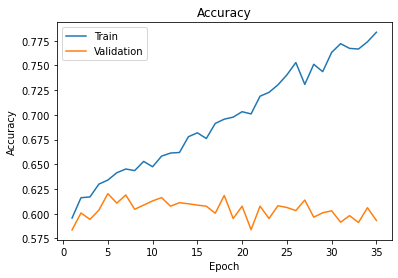

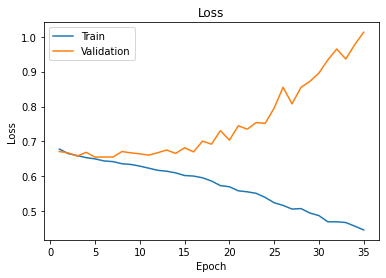

In [ ]:
ANN_net = ANN()
# output, recon, recon_total, information = train(model=ANN_net, batch_size=300, num_epochs=35, learning_rate=0.005)
train(model=ANN_net, batch_size=215, num_epochs=35, learning_rate=0.005)
# BS = 30, learning rate = 1e-5
#0.007 better, 0.003 worked better than 0.001
# BS = 300, learning rate = 0.005, num_epochs=35
# March 27 - Best BS = 200, Learning Rate = 0.005 and Num Epochs = 35

In [ ]:
runTest(model=ANN_net, batch_size=215)

Batch 0 out of 18
Batch 1 out of 18
Batch 2 out of 18
Batch 3 out of 18
Batch 4 out of 18
Batch 5 out of 18
Batch 6 out of 18
Batch 7 out of 18
Batch 8 out of 18
Batch 9 out of 18
Batch 10 out of 18
Batch 11 out of 18
Batch 12 out of 18
Batch 13 out of 18
Batch 14 out of 18
Batch 15 out of 18
Batch 16 out of 18
Batch 17 out of 18
Batch 18 out of 18


In [ ]:
pandaTestCSV = pd.read_csv("testWithSent.csv", index_col=False)
pandaTestCSV[["PetID"]] = petidcsv
pandaTestCSV.to_csv("../../../kaggle/working/testwithsent.csv", index=False)

# Output to csv file
os.chdir("../../../kaggle/working")
os.getcwd()
print(os.listdir("../../../kaggle/working"))
kaggle_submission_table.to_csv("submission.csv", index=False)

In [ ]:
kaggle_submission_table[:3972]

,PetID,AdoptionSpeed
0,e2dfc2935,0
1,f153b465f,1
2,3c90f3f54,0
3,e02abc8a3,1
4,09f0df7d1,1
...,...,...
3967,ae57f8d52,1
3968,83432904d,1
3969,399013029,1
3970,fd80b8c80,1


In [ ]:
kaggle_submission_table.to_csv("submission.csv", index=False)

In [ ]:
kaggle_submission_table = kaggle_submission_table[0:3972]
kaggle_submission_table

,PetID,AdoptionSpeed
0,e2dfc2935,1
1,f153b465f,0
2,3c90f3f54,0
3,e02abc8a3,1
4,09f0df7d1,1
...,...,...
3967,ae57f8d52,1
3968,83432904d,1
3969,399013029,1
3970,fd80b8c80,1


In [ ]:
# Load Winning Team's csv
winningTeamCSV = pd.read_csv("/content/drive/My Drive/3rd Year/APS360 Project/winning_team.csv", index_col=False)
for index, row in winningTeamCSV.iterrows():
    if row.AdoptionSpeed >= 3:
        winningTeamCSV.loc[index, 'AdoptionSpeed'] = 1
    else:
        winningTeamCSV.loc[index, 'AdoptionSpeed'] = 0

In [ ]:
winningTeamCSV

,PetID,AdoptionSpeed
0,e2dfc2935,0
1,f153b465f,0
2,3c90f3f54,0
3,e02abc8a3,1
4,09f0df7d1,1
...,...,...
3967,ae57f8d52,1
3968,83432904d,1
3969,399013029,1
3970,fd80b8c80,1


In [ ]:
results = np.where(winningTeamCSV['AdoptionSpeed'] == kaggle_submission_table['AdoptionSpeed'], True, False)
totalCorrect = results.sum()

In [ ]:
print(round(totalCorrect/len(winningTeamCSV) * 100,2), "%")

67.8 %


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred, labels = [1, 0])

array([[1176,  678],
       [ 601, 1517]])

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print(tn, fp, fn, tp)

1517 601 678 1176


In [ ]:
os.chdir("/content/drive/My Drive/3rd Year/APS360 Project/")
np.savetxt("annpred.csv", y_pred)
np.savetxt("winningsolution-y_true.csv", y_true)

## IGNORE

Training Accuracy: 60.21% Current epoch:  0
Validation Accuracy: 59.03% Current epoch:  0
Training Accuracy: 61.26% Current epoch:  1
Validation Accuracy: 59.65% Current epoch:  1
Training Accuracy: 62.45% Current epoch:  2
Validation Accuracy: 60.38% Current epoch:  2
Training Accuracy: 58.86% Current epoch:  3
Validation Accuracy: 57.09% Current epoch:  3
Training Accuracy: 62.19% Current epoch:  4
Validation Accuracy: 60.16% Current epoch:  4
Training Accuracy: 63.78% Current epoch:  5
Validation Accuracy: 61.09% Current epoch:  5
Training Accuracy: 64.05% Current epoch:  6
Validation Accuracy: 61.09% Current epoch:  6
Training Accuracy: 64.35% Current epoch:  7
Validation Accuracy: 60.96% Current epoch:  7
Training Accuracy: 64.51% Current epoch:  8
Validation Accuracy: 60.6% Current epoch:  8
Training Accuracy: 65.37% Current epoch:  9
Validation Accuracy: 61.34% Current epoch:  9
Training Accuracy: 65.72% Current epoch:  10
Validation Accuracy: 61.41% Current epoch:  10
Training 

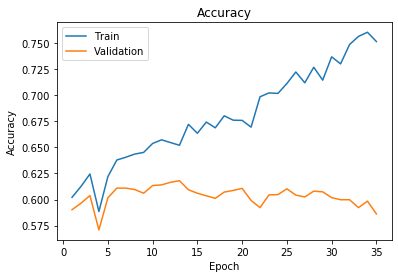

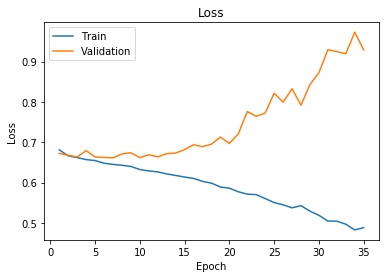

In [ ]:
ANN_net = ANN()
# output, recon, recon_total, information = train(model=ANN_net, batch_size=300, num_epochs=35, learning_rate=0.005)
train(model=ANN_net, batch_size=200, num_epochs=35, learning_rate=0.005)
# BS = 30, learning rate = 1e-5
#0.007 better, 0.003 worked better than 0.001
# BS = 300, learning rate = 0.005, num_epochs=35
# March 27 - Best BS = 200, Learning Rate = 0.005 and Num Epochs = 35




---



---



---



---



---



---



---


---



---



---



---



---



---



---



---



---



---



# Demo

Sparky

![Sparky](https://drive.google.com/uc?id=1AhLvS820Oe3rJzekywfU-cVXUKCMIgKr)





*The data has been preprocessed*. Note that Sparky's profile was left as a hold out for the demo.

In [ ]:
finalTableTest.loc[[1984]]##this is sparky's profile!

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,SentimentScore,BreedRating,Emotion,Age_binary,PetID
1984,1.0,0.019231,0.862295,0.0,0.5,0.0,1.0,0.0,0.333333,0.5,0.5,0.5,0.5,0.0,0.0,0.0,0.021978,0.4,0,0.133333,0.5,1984


after running the data through the ANN....

In [ ]:
y_true = winningTeamCSV['AdoptionSpeed']
y_pred = kaggle_submission_table['AdoptionSpeed'].astype(int)

In [ ]:
y_pred[1984] #ANN prediction

0

In [ ]:
y_true[1984] #Actual adoption speed

0

In [ ]:
if y_pred[1984] ==0:
  print("The ANN predicts Sparky gets adopted within a month!")

if y_true[1984] == y_pred[1984]:
  print("The ANN predicted correctly!")

The ANN predicts Sparky gets adopted within a month!
The ANN predicted correctly!
